# Placeholder for Title & Photo

# Placeholder for describing goal of this Notebook

This notebook is based on the article [Marketing Channel Attribution with Markov Chains in Python](https://towardsdatascience.com/marketing-channel-attribution-with-markov-chains-in-python-part-2-the-complete-walkthrough-733c65b23323)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict

%matplotlib inline

# Data Load

In [2]:
data_df = pd.read_csv('attribution_data.csv')

In [3]:
data_df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586737 entries, 0 to 586736
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cookie            586737 non-null  object 
 1   time              586737 non-null  object 
 2   interaction       586737 non-null  object 
 3   conversion        586737 non-null  int64  
 4   conversion_value  586737 non-null  float64
 5   channel           586737 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 26.9+ MB


In [5]:
data_df.describe()

,conversion,conversion_value
count,586737.000000,586737.000000
mean,0.030063,0.187871
std,0.170760,1.084498
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,8.500000


# EDA

In [6]:
data_df['channel'].unique()

array(['Instagram', 'Online Display', 'Paid Search', 'Facebook',
       'Online Video'], dtype=object)

# Data Preprocessing

In [7]:
data_df = data_df.sort_values(['cookie', 'time'], ascending=[False, True])

In [8]:
data_df['visit_order'] = data_df.groupby('cookie').cumcount() + 1

In [9]:
data_df.head()

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search,1
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video,2
586731,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-06T23:30:38Z,impression,0,0.0,Online Display,1
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display,2


In [10]:
df_paths = data_df.groupby('cookie')['channel'].aggregate(
    lambda x: x.unique().tolist()).reset_index()

In [11]:
df_paths.head(1)

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]"


In [12]:
df_last_interaction = data_df.drop_duplicates('cookie', keep='last')[
    ['cookie', 'conversion']]

In [13]:
df_last_interaction.head(1)

,cookie,conversion
586736,ooooohAFofEnonEikhAi3fF9o,0


In [14]:
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

In [15]:
df_paths.head(1)

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0


In [16]:
#df_paths = df_paths.drop('conversion_x', axis=1)

In [17]:
#df_paths = df_paths.rename(columns={'conversion_y': 'conversion'})

In [18]:
# df_paths.head(1)

In [19]:
# df_paths.info()

In [20]:
df_paths['path'] = np.where(
    df_paths['conversion'] == 0,
    ['Start, '] + df_paths['channel'].apply(', '.join) + [', Null'],
    ['Start, '] + df_paths['channel'].apply(', '.join) + [', Conversion'])

In [21]:
df_paths.head()

,cookie,channel,conversion,path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0,"Start, Instagram, Online Display, Null"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0,"Start, Paid Search, Null"
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0,"Start, Paid Search, Null"
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,"Start, Instagram, Null"
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,"Start, Paid Search, Null"


In [22]:
df_paths['path'] = df_paths['path'].str.split(', ')

In [23]:
df_paths.head()

,cookie,channel,conversion,path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,"[Start, Paid Search, Null]"


In [24]:
df_paths = df_paths[['cookie', 'path']]

In [25]:
df_paths.head(1)

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Start, Instagram, Online Display, Null]"


# Markov Chains

## 1. Generate the Transition Matrix 

Calculate transition probabilities between all states in our state-space

In [26]:
list_of_paths = df_paths['path']
list_of_paths

0         [Start, Instagram, Online Display, Null]
1                       [Start, Paid Search, Null]
2                       [Start, Paid Search, Null]
3                         [Start, Instagram, Null]
4                       [Start, Paid Search, Null]
                            ...                   
240103               [Start, Online Display, Null]
240104               [Start, Online Display, Null]
240105               [Start, Online Display, Null]
240106    [Start, Paid Search, Online Video, Null]
240107                  [Start, Paid Search, Null]
Name: path, Length: 240108, dtype: object

In [27]:
total_conversions = sum(path.count('Conversion')
                        for path in df_paths['path'].tolist())

In [28]:
base_conversion_rate = total_conversions / len(list_of_paths)

In [29]:
def transition_states(list_of_paths):
    """
    This function: 
        1. generates a list of all unique channels (=touch points)
        2. creates a transition dictionary with keys being the cartesian product of the unique channels and values=0
           ex.:  'Facebook>Instagram': 0
        3. calculates, while looping through the user_paths from list_of_paths, the position of every channel different than Null & Conversion 
        4. based on the channel's position, "cuts out" of the user_path the channel itself & the following channel in a two-state transition   
           and matches it to the corresponding transition in the transition_states dictionary 
        5. increases the value of the two-state transition in the transition_states dictionary by 1

    Args: 
        - list_of_paths - a list containing the touch points in the customer journey of the user. 
                          In terms of our data: it sorts the channels (=touch points) chronologically (via the time stamp) per cookie (=user_id). 

    Returns:
        - transitions_states - a dictionary containing the frequency of the two-state transition 
          ex: 'Online Video>Paid Search': 1964


    """
    list_of_unique_channels = set(
        x for element in list_of_paths for x in element)
    transition_states = {
        x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(
                        user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] +
                                          '>' + user_path[col+1]] += 1

    return transition_states

In [30]:
trans_states = transition_states(list_of_paths)

info on defaultdict: https://www.geeksforgeeks.org/defaultdict-in-python/#:~:text=Defaultdict%20is%20a%20sub%2Dclass,key%20that%20does%20not%20exists.

In [31]:
def transition_prob(trans_states):
    """
    This function: 
        1. takes a dictionary containing the frequency of a two-state transition, i.e. two consecutive touch points
        2. sums up the occurences per channel 
        3. calculates the probability of a certain state transition
           = state transition frequency / total occurences of channel (=start state)

    Args: 
        - trans_dict -  a dictionary containing the frequency of the two-state combination 
          ex: 'Online Video>Paid Search': 1964

    Returns: 
        - trans_prob - a dictionary containing all transitions and their respective transition probabilities given the historical data 

    """

    list_of_unique_channels = set(
        x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_states) if state + '>' in s]
            for col in index:
                if trans_states[list(trans_states)[col]] > 0:
                    counter += trans_states[list(trans_states)[col]]
            for col in index:
                if trans_states[list(trans_states)[col]] > 0:
                    state_prob = float(
                        (trans_states[list(trans_states)[col]])) / float(counter)
                    trans_prob[list(trans_states)[col]] = state_prob

    return trans_prob

In [32]:
trans_prob = transition_prob(trans_states)

In [33]:
def transition_matrix(list_of_paths, transition_probabilities):
    """
    This function transforms the transition probability dictionary into a data frame.

    Args: 
        - list_of_paths - a list containing the touch points in the customer journey of the user. 
                          In terms of our data: it sorts the channels (=touch points) chronologically (via the time stamp) per cookie (=user_id).
        - transition_probabilites - a dictionary containing all transitions and their respective transition probabilities given the historical data


    Returns: 
        - trans_matrix - a data frame with the transition probabilities per channel

    """

    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(
        x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in [
            'Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix

In [34]:
trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [35]:
trans_matrix

,Facebook,Instagram,Online Display,Conversion,Null,Start,Paid Search,Online Video
Facebook,0.000000,0.173072,0.024352,0.053220,0.673123,0.0,0.050655,0.025577
Instagram,0.218777,0.000000,0.023531,0.057979,0.629786,0.0,0.045809,0.024118
Online Display,0.053986,0.029363,0.000000,0.050324,0.756643,0.0,0.092386,0.017299
Conversion,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
Null,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
Start,0.278408,0.119188,0.142644,0.000000,0.000000,0.0,0.317399,0.142361
Paid Search,0.064442,0.034196,0.048053,0.053309,0.770779,0.0,0.000000,0.029221
Online Video,0.059323,0.031908,0.018920,0.078146,0.763757,0.0,0.047947,0.000000


How to custom sort a string index: https://stackoverflow.com/questions/50012525/how-to-sort-pandas-dataframe-by-custom-order-on-string-index

In [36]:
reorder_list = ['Start', 'Online Video', 'Paid Search', 'Facebook', 
                'Online Display', 'Instagram', 'Conversion', 'Null']

In [37]:
trans_matrix = trans_matrix.reindex(reorder_list)
trans_matrix

,Facebook,Instagram,Online Display,Conversion,Null,Start,Paid Search,Online Video
Start,0.278408,0.119188,0.142644,0.000000,0.000000,0.0,0.317399,0.142361
Online Video,0.059323,0.031908,0.018920,0.078146,0.763757,0.0,0.047947,0.000000
Paid Search,0.064442,0.034196,0.048053,0.053309,0.770779,0.0,0.000000,0.029221
Facebook,0.000000,0.173072,0.024352,0.053220,0.673123,0.0,0.050655,0.025577
Online Display,0.053986,0.029363,0.000000,0.050324,0.756643,0.0,0.092386,0.017299
Instagram,0.218777,0.000000,0.023531,0.057979,0.629786,0.0,0.045809,0.024118
Conversion,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
Null,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000


In [38]:
trans_matrix = trans_matrix[reorder_list]
trans_matrix

,Start,Online Video,Paid Search,Facebook,Online Display,Instagram,Conversion,Null
Start,0.0,0.142361,0.317399,0.278408,0.142644,0.119188,0.000000,0.000000
Online Video,0.0,0.000000,0.047947,0.059323,0.018920,0.031908,0.078146,0.763757
Paid Search,0.0,0.029221,0.000000,0.064442,0.048053,0.034196,0.053309,0.770779
Facebook,0.0,0.025577,0.050655,0.000000,0.024352,0.173072,0.053220,0.673123
Online Display,0.0,0.017299,0.092386,0.053986,0.000000,0.029363,0.050324,0.756643
Instagram,0.0,0.024118,0.045809,0.218777,0.023531,0.000000,0.057979,0.629786
Conversion,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Null,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


# Place Holder for Analysis

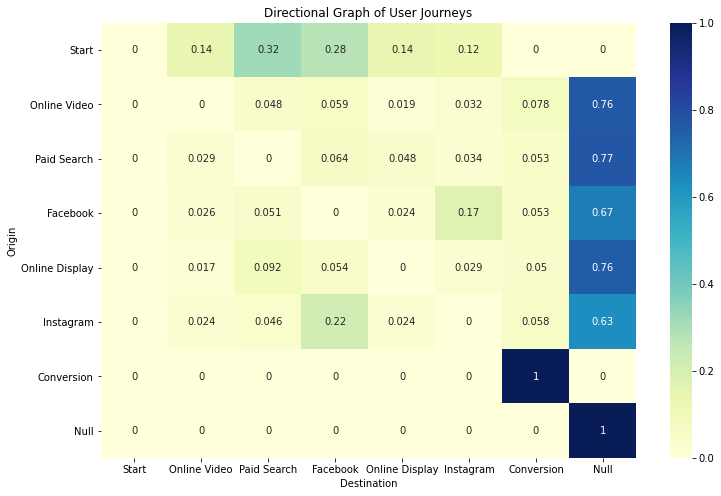

In [40]:
plt.figure(figsize=(12,8))

ax = sns.heatmap(trans_matrix, annot=True, cmap="YlGnBu")
ax.set(title='Directional Graph of User Journeys', xlabel='Destination', ylabel='Origin');

## 2. Calculate Removal Effects

In [47]:
def removal_effects(trans_matrix, conversion_rate):
    """
    This function: 
    
    - Args: 
        - trans_matrix
        - conversion_rate
        
    - Returns: 
        - removal_effects_dict
    """
    
    removal_effects_dict = {}
    channels = trans_matrix.columns
    channels = channels.drop(['Start', 'Null', 'Conversion'])
    
    for channel in channels:
        removal_df = trans_matrix.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0
        
        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null','Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)
        
        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        
        removal_dot_prod = np.dot(removal_inv_diff, np.assaray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod, 
                                  index=removal_to_conv.index)[[1]].loc['Start'].values[0]       
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect
    
    return removal_effects_dict

Questions: 
- do we really need 'Start'
- more elegenat ways in the functions (instead of fors)